In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

# Definisci le dimensioni desiderate per le immagini
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3  # Numero di canali dell'immagine RGB

# Percorso delle cartelle contenenti le immagini e le maschere
data_folder = "../training_data"
images_folder = os.path.join(data_folder, "horses")
masks_folder = os.path.join(data_folder, "masks")

# Ottieni l'elenco dei nomi dei file delle immagini
train_ids = os.listdir(images_folder)

# Inizializza gli array X e y
X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

# Ciclo su tutte le immagini
for i, image_name in enumerate(train_ids):
    # Leggi l'immagine
    image_path = os.path.join(images_folder, image_name)
    image = cv2.imread(image_path)
    # Riscalala alle dimensioni desiderate
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    # Salva l'immagine nell'array X
    X[i] = image
    
    
    # Leggi la maschera corrispondente
    mask_path = os.path.join(masks_folder, image_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # Riscalala alle dimensioni desiderate
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    # Aggiungi una dimensione per il canale (1 canale per la maschera)
    mask = np.expand_dims(mask, axis=-1)
    # Salva la maschera nell'array y
    y[i] = mask

# Adesso X contiene le immagini e y contiene le rispettive maschere, entrambe riscalate alle dimensioni desiderate

# splitto per training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)  

In [7]:
import tensorflow as tf

# Definizione dell'input
inputs = tf.keras.layers.Input(shape=(None, None, 3))

# Funzione per il blocco convoluzionale
def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same'):
    conv = tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    return conv

# Definizione dell'encoder
def encoder(inputs):
    c1 = conv_block(inputs, 16)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 32)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 64)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 128)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, 256)
    return c5, [c1, c2, c3, c4]

# Definizione del decoder
def decoder(inputs, encoder_output):
    c5, skips = encoder_output

    u1 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    concat1 = tf.keras.layers.concatenate([u1, skips[3]], axis=3)
    c6 = conv_block(concat1, 128)

    u2 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    concat2 = tf.keras.layers.concatenate([u2, skips[2]], axis=3)
    c7 = conv_block(concat2, 32)

    u3 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    concat3 = tf.keras.layers.concatenate([u3, skips[1]], axis=3)
    c8 = conv_block(concat3, 32)

    u4 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    concat4 = tf.keras.layers.concatenate([u4, skips[0]], axis=3)
    c9 = conv_block(concat4, 16)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    return outputs

# Chiamata all'encoder
encoder_output = encoder(inputs)

# Chiamata al decoder con input e output dell'encoder
outputs = decoder(inputs, encoder_output)

# Creazione del modello
model = tf.keras.models.Model(inputs, outputs)


In [8]:
# Compila il modello prima di utilizzarlo per l'addestramento
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Definisci i callback
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Addestramento del modello
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=100, callbacks=callbacks)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5327 - loss: 2.4628 - val_accuracy: 0.7346 - val_loss: 0.5983
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7335 - loss: 0.6110 - val_accuracy: 0.7352 - val_loss: 0.5649
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.7471 - loss: 0.5582 - val_accuracy: 0.7441 - val_loss: 0.5519
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.7458 - loss: 0.5507 - val_accuracy: 0.7534 - val_loss: 0.5193
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7613 - loss: 0.5202 - val_accuracy: 0.7578 - val_loss: 0.4963
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.7817 - loss: 0.4717 - val_accuracy: 0.8176 - val_loss: 0.3997
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8448 - loss: 0.3697 - val_accuracy: 0.8762 - val_loss: 0.3315
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8701 - loss: 0.3338 - val_accuracy: 0.8859 - v

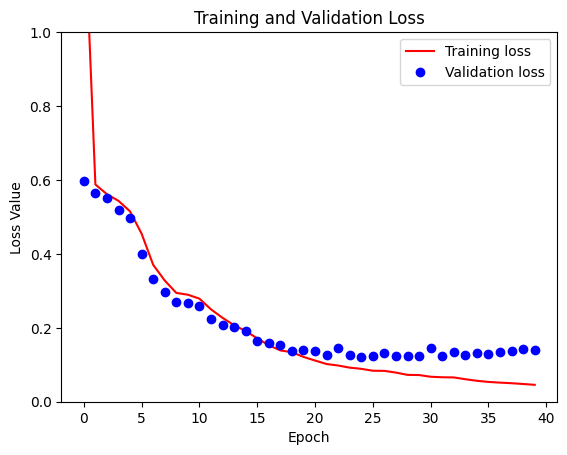

In [9]:
import matplotlib.pyplot as plt
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


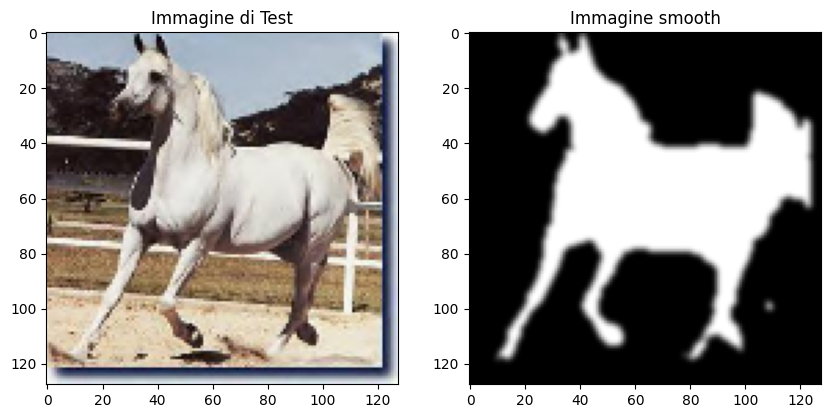

In [10]:
from ctypes import resize
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

#   DA TENERE 050 - 045 - 037 - 267 - 041 (pos) 
# Carica l'immagine di test
test_image_path = "../training_data/horses/horse273.png" # 218 283 315 273
test_image = np.array(Image.open(test_image_path)) 
# Ridimensiona l'immagine di test alle dimensioni desiderate
rescaled_test_image = cv2.resize(test_image, (IMG_HEIGHT, IMG_WIDTH))

# Fai una predizione sull'immagine di test
predicted_mask = model.predict(np.expand_dims(rescaled_test_image, axis=0))[0]
# Soglia per la maschera predetta
threshold = 0.5  # Puoi regolare questa soglia secondo le tue esigenze
# Applica la soglia alla maschera predetta
binary_mask = predicted_mask > threshold

# Visualizza l'immagine di test
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rescaled_test_image)
plt.title('Immagine di Test')

# Visualizza la maschera predetta
# Applica un filtro Gaussiano per rendere l'immagine più smooth
smoothed_mask = cv2.GaussianBlur(binary_mask.astype(float), (5, 5), 0)
# Plot dell'immagine originale e dell'immagine smooth
plt.subplot(1, 2, 2)
plt.imshow(smoothed_mask, cmap='gray')
plt.title('Immagine smooth')
plt.show()
